# 1. Problem Statement

We are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

* toxic
* severe_toxic
* obscene
* threat
* insult
* dentity_hate

We must create a model which predicts a probability of each type of toxicity for each comment.

It is a Supervised Learning and Multiclass Classification Problem.


In [2]:
#importing necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. Data Collection

For our dataset we are using Kaggle dataset provided by Jigsaw under their competition.

Dataset Link-https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

In [4]:
df=pd.read_csv("/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
#Example of a toxic comment in our dataset
df.iloc[12]

id                                                0005c987bdfc9d4b
comment_text     Hey... what is it..\n@ | talk .\nWhat is it......
toxic                                                            1
severe_toxic                                                     0
obscene                                                          0
threat                                                           0
insult                                                           0
identity_hate                                                    0
Name: 12, dtype: object

#3. Data Preprocessing

Here it involves following steps:



*   Tokenization-https://vaclavkosar.com/ml/Tokenization-in-Machine-Learning-Explained
*   Creation of Training,Test and Validation set



In [7]:
#Tokenization
from tensorflow.keras.layers import TextVectorization

In [8]:
x=df["comment_text"]
y=df[df.columns[2:]].values #conerts int a numpy array.

In [9]:
x.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [10]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [11]:
MAX_FEATURES=200000 #No. of words in Vocab of machine's language.

In [12]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                            standardize="lower_and_strip_punctuation",
                             output_sequence_length=1800,
                             output_mode='int')

In [13]:
vectorizer.adapt(x.values)

In [14]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [15]:
#Example of working vectorizer encoding a scentence
vectorizer("Hello World, life is Great")[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([288, 263, 306,   9, 275])>

In [16]:
vectorized_text = vectorizer(x.values)

In [17]:
vectorized_text # the shape tells us that we have size of 159751 scentences, each scentence with max length of 1800 words and if some scentences are shorter, we fill it out with 0s

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [18]:
# Creating a dataset generation pipeline
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset=dataset.cache()
dataset=dataset.shuffle(160000)
dataset=dataset.batch(256)
dataset=dataset.prefetch(2)

In [19]:
dataset.as_numpy_iterator().next()

(array([[   37,   165,  1684, ...,     0,     0,     0],
        [    8,    69,    40, ...,     0,     0,     0],
        [  147,     8,    19, ...,     0,     0,     0],
        ...,
        [   70,   265,  1955, ...,     0,     0,     0],
        [    7,   152,   397, ...,     0,     0,     0],
        [  827, 25318,  2786, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0]]))

In [20]:
len(dataset)

624

In [21]:
#Creation of Training,Test and Validation set
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [22]:
train_generator=train.as_numpy_iterator()

In [23]:
train_generator.next()

(array([[ 1272,    50,    10, ...,     0,     0,     0],
        [   24,  3925, 79577, ...,     0,     0,     0],
        [ 2075,   917,  1540, ...,     0,     0,     0],
        ...,
        [   38,     9,   506, ...,     0,     0,     0],
        [ 1897,   274,   799, ...,     0,     0,     0],
        [    7,    20,    50, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0]]))

#4. Model Creation



*   Embedding - repersentation of word with certain features as integer or floats.
*   We create a Sequential model, use LSTM layer.

For more info, refer to - https://www.tensorflow.org/guide/keras/working_with_rnns#:~:text=There%20are%20three%20built%2Din,be%20fed%20to%20next%20timestep.



In [24]:
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional,Dense,Embedding
from tensorflow.keras.models import Sequential

In [25]:
# We are instaniating a neural network and add hidden layers in neural network,accordingily.
model = Sequential()
#Creating Embedding Layer
model.add(Embedding(MAX_FEATURES+1,32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32,activation='tanh')))
# Feature Extractor Fully connected layers
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
#Output Mapping layers
model.add(Dense(6,activation='sigmoid'))

In [26]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [28]:
history=model.fit(train,epochs=20,validation_data=val)

Epoch 1/20
436/436 [==============================] - 142s 300ms/step - loss: 0.0968 - val_loss: 0.0516
Epoch 2/20
436/436 [==============================] - 100s 230ms/step - loss: 0.0464 - val_loss: 0.0412
Epoch 3/20
436/436 [==============================] - 86s 198ms/step - loss: 0.0407 - val_loss: 0.0372
Epoch 4/20
436/436 [==============================] - 75s 172ms/step - loss: 0.0384 - val_loss: 0.0373
Epoch 5/20
436/436 [==============================] - 66s 152ms/step - loss: 0.0352 - val_loss: 0.0323
Epoch 6/20
436/436 [==============================] - 67s 153ms/step - loss: 0.0327 - val_loss: 0.0323
Epoch 7/20
436/436 [==============================] - 62s 142ms/step - loss: 0.0308 - val_loss: 0.0281
Epoch 8/20
436/436 [==============================] - 60s 138ms/step - loss: 0.0279 - val_loss: 0.0259
Epoch 9/20
436/436 [==============================] - 61s 140ms/step - loss: 0.0256 - val_loss: 0.0242
Epoch 10/20
436/436 [==============================] - 57s 130ms/step -

In [29]:
history.history

{'loss': [0.09681659936904907,
  0.04638935253024101,
  0.04067002236843109,
  0.03841297701001167,
  0.03518524393439293,
  0.03273627161979675,
  0.030814705416560173,
  0.027922051027417183,
  0.02555750124156475,
  0.02325843833386898,
  0.02122807875275612,
  0.01831147074699402,
  0.017040658742189407,
  0.014993404969573021,
  0.01441896427422762,
  0.012844787910580635,
  0.011804849840700626,
  0.010613549500703812,
  0.010157046839594841,
  0.009198460727930069],
 'val_loss': [0.0516284815967083,
  0.041219569742679596,
  0.037164248526096344,
  0.03725411370396614,
  0.032317664474248886,
  0.03229381889104843,
  0.028106190264225006,
  0.025875387713313103,
  0.02419201284646988,
  0.021649513393640518,
  0.017789188772439957,
  0.016951508820056915,
  0.015227549709379673,
  0.013358273543417454,
  0.012202768586575985,
  0.010359846986830235,
  0.010559885762631893,
  0.008632122538983822,
  0.008481208235025406,
  0.007739328779280186]}

<Figure size 800x500 with 0 Axes>

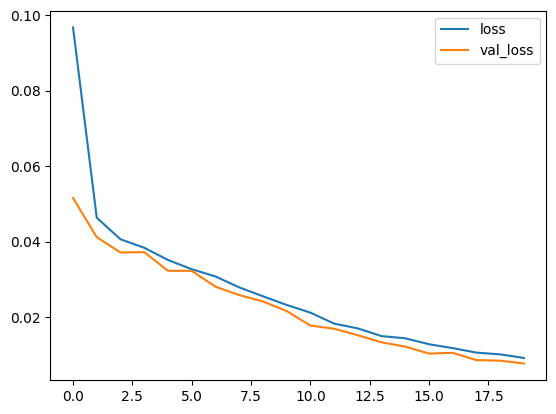

In [48]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

#5. Making Predictions

To make predictions on our model, we need to tokenize our test input.

In [30]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [31]:
input_text=vectorizer("You are terrible")
input_text[:3]

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([   7,   20, 2982])>

In [32]:
batch=test.as_numpy_iterator().next()

In [33]:
np.expand_dims(input_text,0) #We do so because our model is expecting a batch as input rather than a single text

array([[   7,   20, 2982, ...,    0,    0,    0]])

In [34]:
res=model.predict(np.expand_dims(input_text,0))
res

1/1 [==============================] - 1s 773ms/step


array([[9.1193825e-01, 1.2054272e-05, 3.4554407e-03, 1.8811552e-05,
        9.0501092e-02, 8.0075784e-05]], dtype=float32)

In [35]:
# batch prediction
batch_x,batch_y=test.as_numpy_iterator().next()

In [36]:
(model.predict(batch_x)>0.5).astype(int)

8/8 [==============================] - 0s 48ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

#6. Evaluating Model

Since, we have multiple binary outputs,we will use binary metrics like **precision** and **recall**.

In [37]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [38]:
pre=Precision()
re=Recall()
acc=CategoricalAccuracy()

In [39]:
#setting up test pipeline
for batch in test.as_numpy_iterator():
  #Unpack the batch
  x_true, y_true = batch

  #Make a prediction
  y_predict=model.predict(x_true)

  #Flatten the predictions
  y_true=y_true.flatten()
  y_predict=y_predict.flatten()

  #Updating the scores
  pre.update_state(y_true,y_predict)
  re.update_state(y_true,y_predict)
  acc.update_state(y_true,y_predict)

8/8 [==============================] - 0s 34ms/step


In [40]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9538193345069885, Recall:0.9681603908538818, Accuracy:0.032258063554763794


#7. Model Deployment

In this, we use Gradio library from Python to create a web application for our model.

In [41]:
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 10.1 MB/s eta 0

In [42]:
import gradio as gr

In [43]:
def score_comment(comment):
  vectorized_comment=vectorizer([comment])
  results=model.predict(vectorized_comment)

  text=''
  for idx,col in enumerate(df.columns[2:]):
    text+='{} : {}\n'.format(col,results[0][idx]>0.5)

  return text

In [44]:
interface=gr.Interface(fn=score_comment,
                       inputs=gr.inputs.Textbox(lines=2,placeholder="Enter the comment"),
                       outputs='text')

<ipython-input-44-f55dd3f47e98>:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Textbox(lines=2,placeholder="Enter the comment"),
<ipython-input-44-f55dd3f47e98>:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2,placeholder="Enter the comment"),
<ipython-input-44-f55dd3f47e98>:2: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2,placeholder="Enter the comment"),


In [45]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://768a29b86ec63b6aab.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
